In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from keras.utils import to_categorical
from keras.models import load_model
from utils import prepare_data
from dataloaders import GeneDataLoader
from plotting import box_plot_array, scatter_plot
from utils import extractY



In [9]:
def one_hot_emb(data: pd.DataFrame) -> pd.DataFrame:
    mapping = {
        'A': 0,
        'C': 1,
        'G': 2,
        'T': 3
    }
    one_hot_encode_lam = lambda seq: to_categorical([mapping[x] for x in seq])
    return data.apply(one_hot_encode_lam)

def exclude_zero_gradients(gradient):
    value = np.sum(gradient)
    return value is None or value == 0.0

In [11]:
"""
    Integrated Gradients
"""
from motif_search import motif_utilities

model_name = "CNN_RNN_no_str"

model = load_model(f'{model_name}.h5',compile=False)

struct = False

m6A = False

In [12]:
train_data, valid_data, test_data = prepare_data()

# max_seq_len = test_data['seq'].apply(lambda x: len(x)).max()

max_seq_len = 34526

dataloader = GeneDataLoader(test_data, shuffle=False, padding_length=max_seq_len, struct=False, m6A=False)

compartments = ["ERM", "KDEL", "LMA", "MITO", "NES", "NIK", "NLS", "NUCP", "OMM"]

data_split_in_compartments = {
    "ERM": [],
    "KDEL": [],
    "LMA": [],
    "MITO": [],
    "NES": [],
    "NIK": [],
    "NLS": [],
    "NUCP": [],
    "OMM": [],
}

prediction = []

test_y = extractY(test_data)

# Add the compartments in their respective cluster
for x_batch, y_batch in dataloader:
    predicted_y = model.predict(x_batch[0])
    prediction.append(predicted_y)
    for i in range(len(predicted_y)):
        index = predicted_y[i].argmax(axis=0)
        data_split_in_compartments[compartments[index]].append({"x": x_batch[0][i], "y": predicted_y[i]})

prediction = np.concatenate(prediction)

1/1 [==============================] - 0s 342ms/step


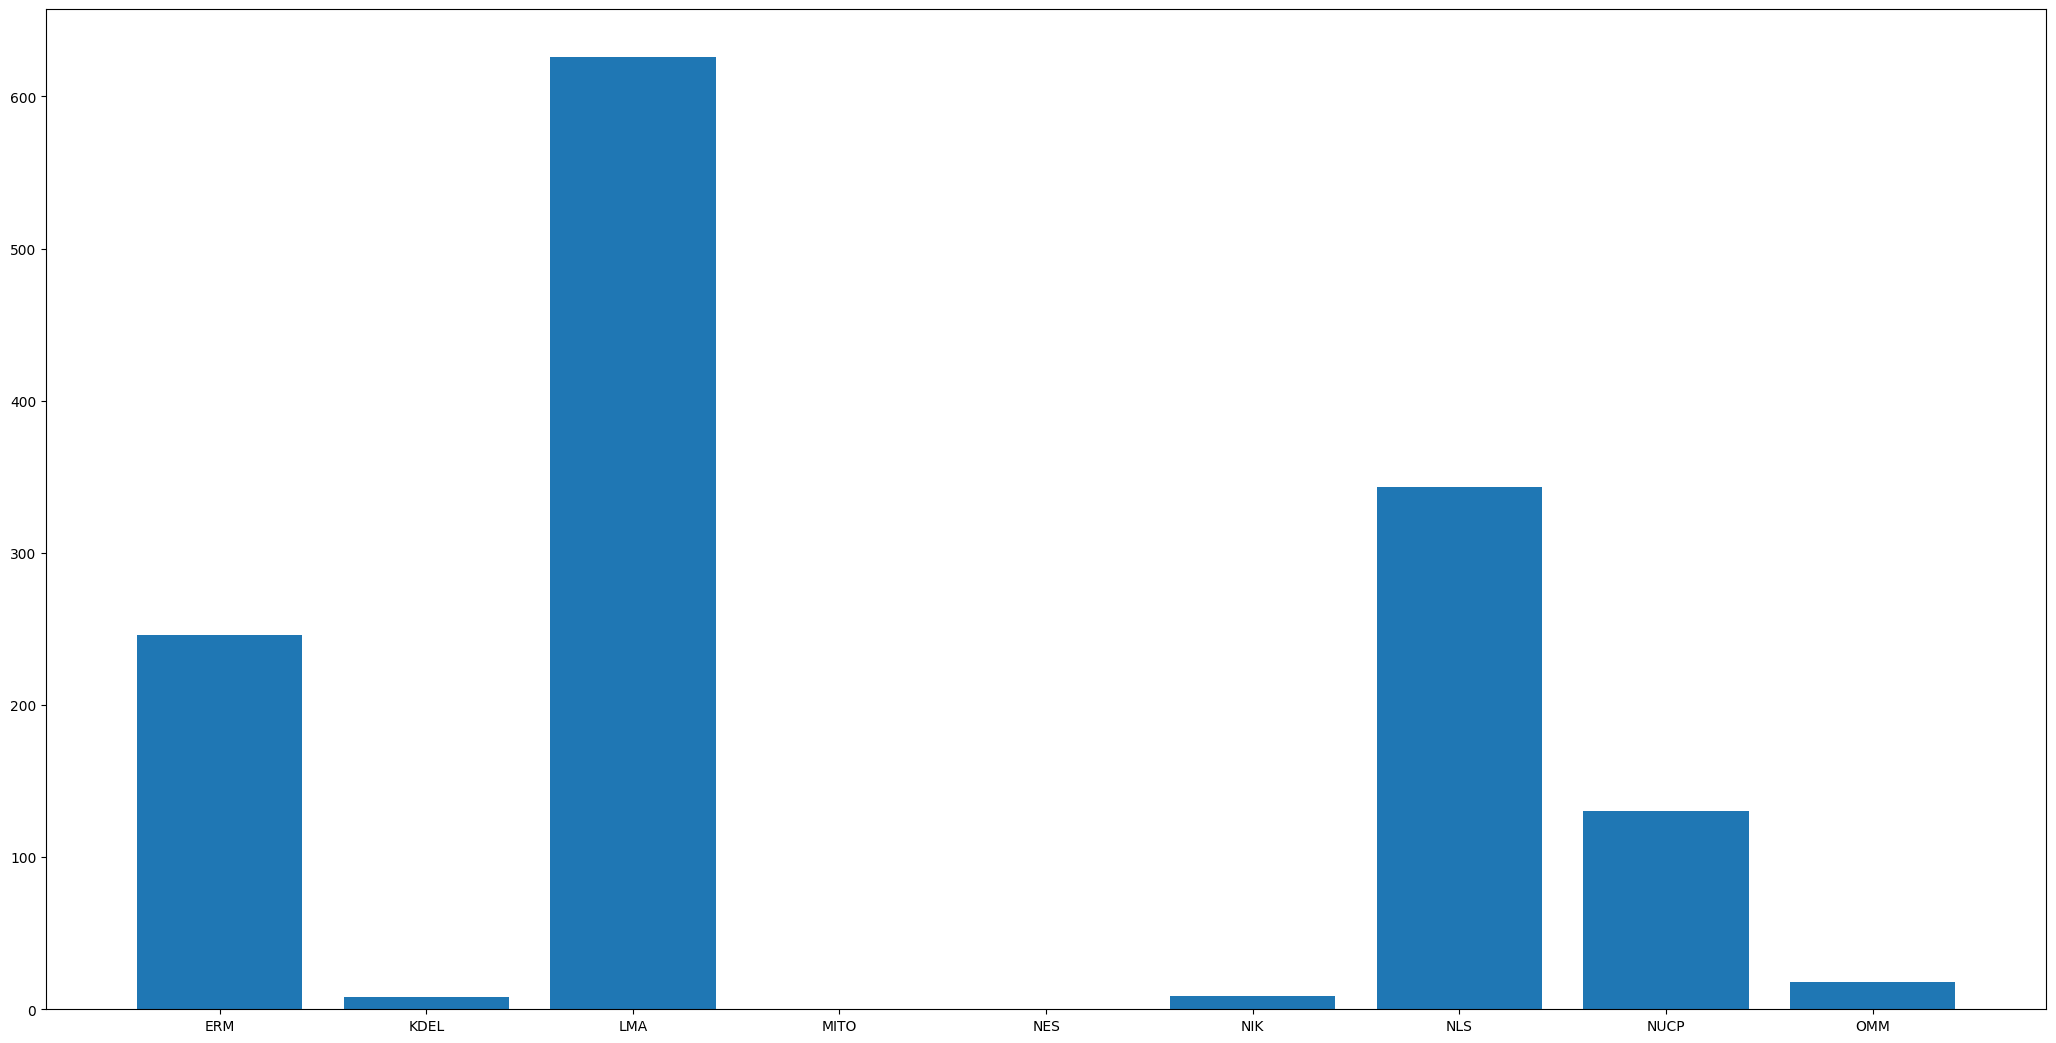

In [13]:
# Plot distribution of most likely compartment

compartment_distribution = [len(data_split_in_compartments[compartment]) for compartment in data_split_in_compartments.keys()]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(compartments,compartment_distribution)
plt.show()

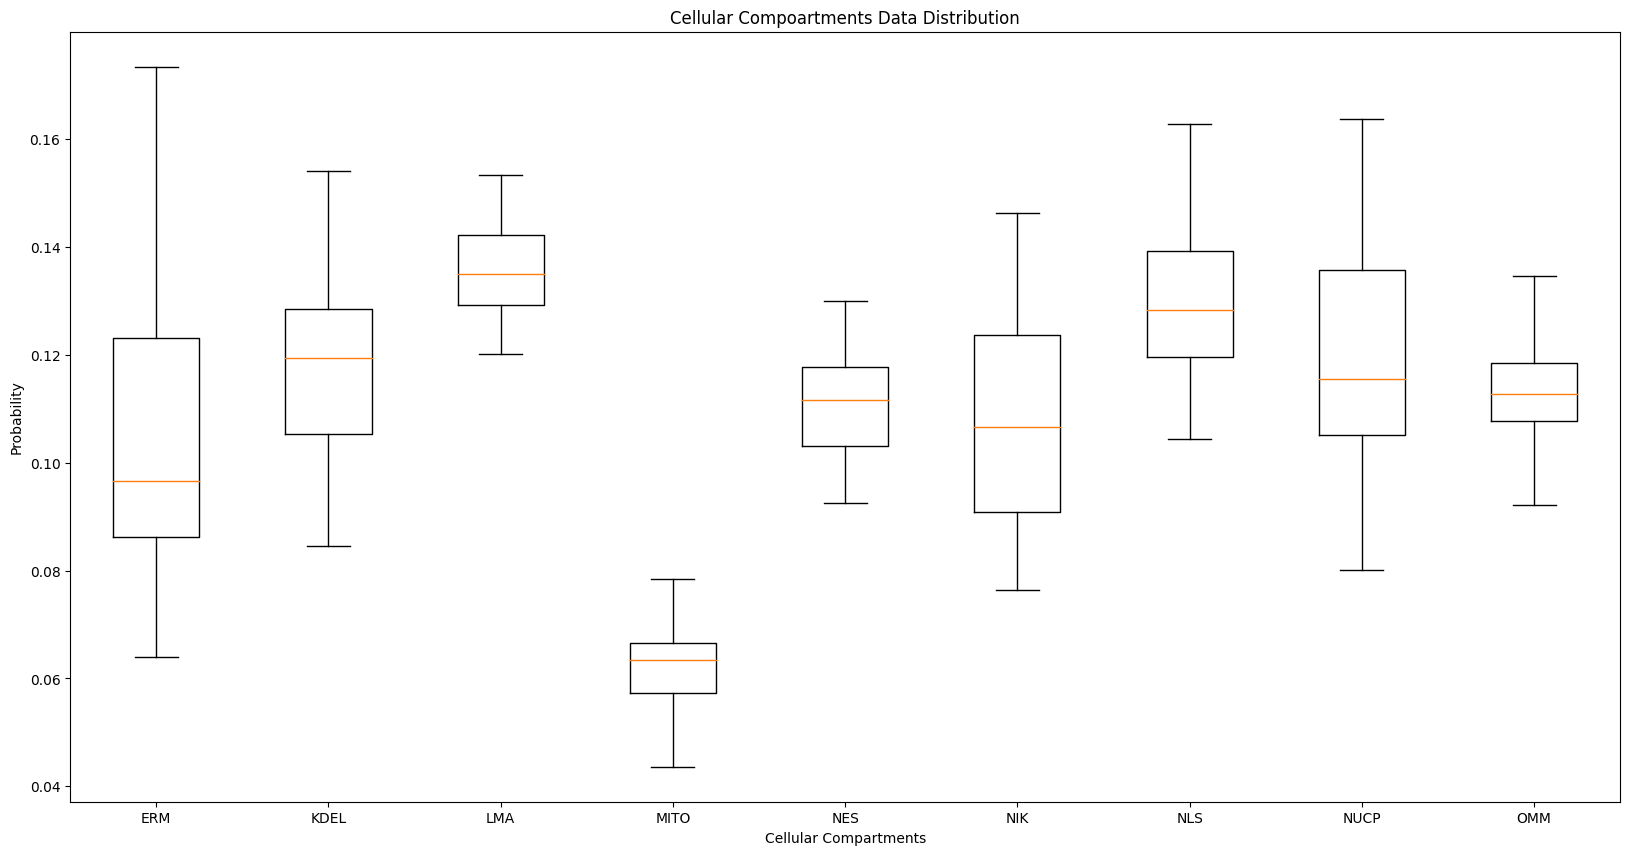

In [14]:
box_plot_array(prediction)

In [ ]:
# scatter_plot(test_y, prediction)

In [15]:
def sort_data(data, index):

    n = len(data)
    swapped = False
    for i in range(n-1):
        for j in range(0, n-i-1):
            if data[j]["y"][index] > data[j + 1]["y"][index]:
                swapped = True
                data[j], data[j + 1] = data[j + 1], data[j]
        if not swapped:
            return

    return data

# Downsample compartments because of computational considerents
number_of_samples = 100

data_split_in_compartments_x = {
    "ERM": [],
    "KDEL": [],
    "LMA": [],
    "MITO": [],
    "NES": [],
    "NIK": [],
    "NLS": [],
    "NUCP": [],
    "OMM": [],
}

for compartment in data_split_in_compartments:
    # data_split_in_compartments[compartment] = random.sample(data_split_in_compartments[compartment],number_of_samples)
    data_list = data_split_in_compartments[compartment]
    sort_data(data_split_in_compartments[compartment], compartments.index(compartment))
    if len(data_split_in_compartments[compartment]) > 30:
        data_split_in_compartments[compartment] = data_split_in_compartments[compartment][-30:]

    for i in range(len(data_split_in_compartments[compartment])):
        data_split_in_compartments_x[compartment].append(data_split_in_compartments[compartment][i]["x"])
    print(f"{compartment} has len: {len(data_split_in_compartments[compartment])}")


ERM has len: 30
KDEL has len: 8
LMA has len: 30
MITO has len: 0
NES has len: 0
NIK has len: 9
NLS has len: 30
NUCP has len: 30
OMM has len: 18


In [16]:
print(data_split_in_compartments_x["ERM"])

for i in range(len(data_split_in_compartments_x["ERM"])):
    print(data_split_in_compartments["ERM"][i]["y"][0])

[array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]], dtype=float32), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32), array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [1., 0., 0

Computing gradient of - ERM


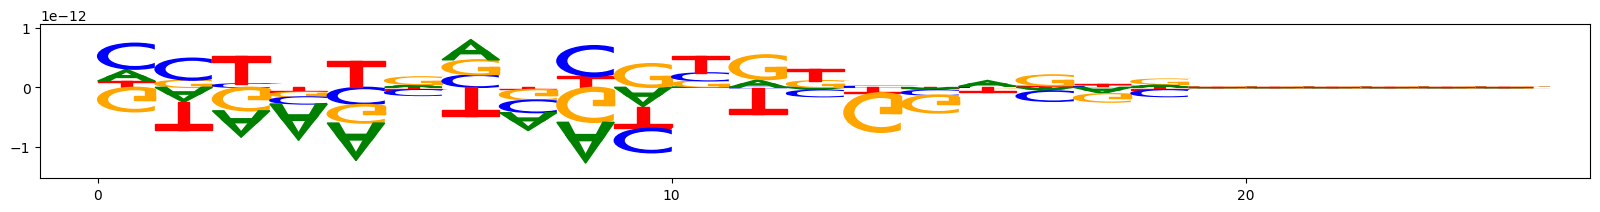

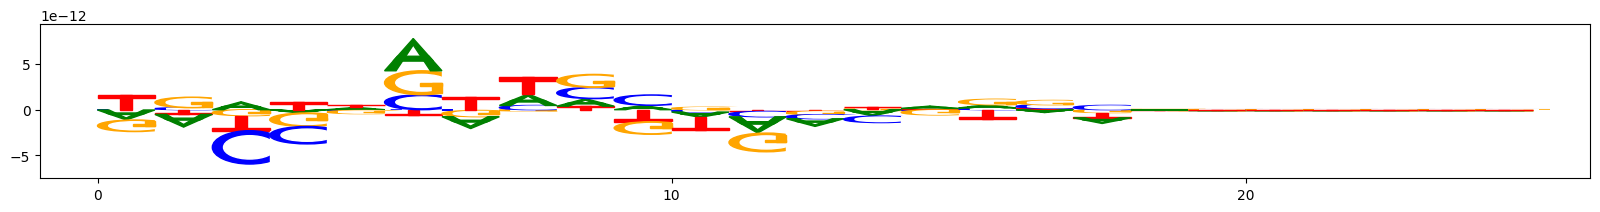

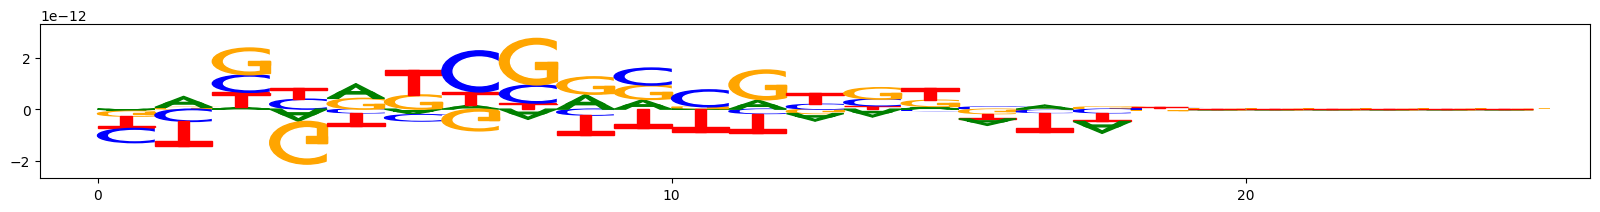

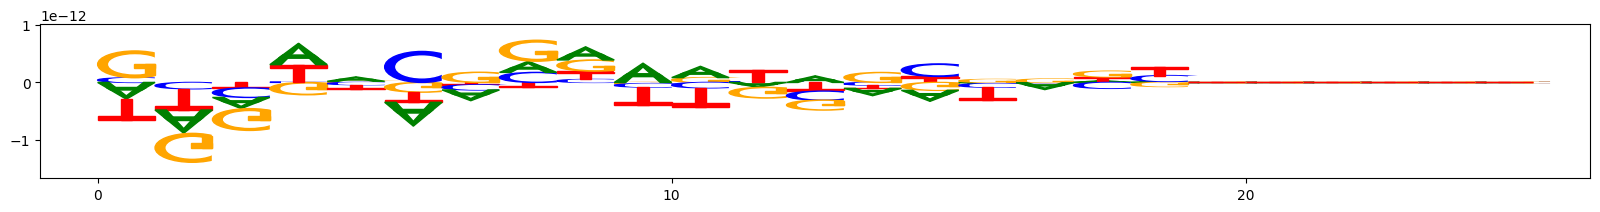

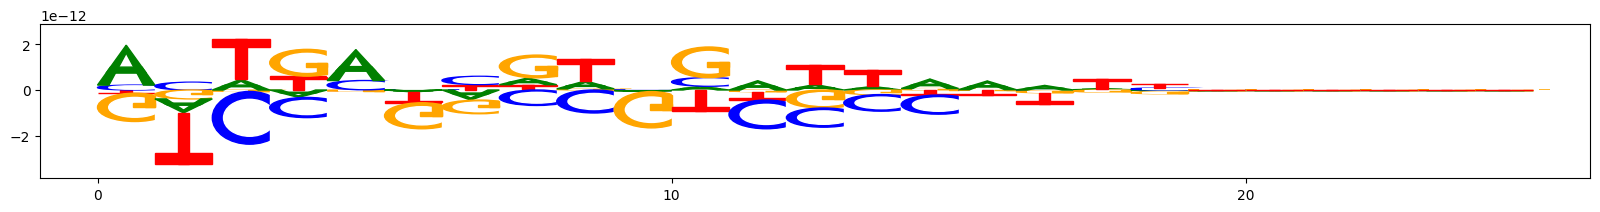

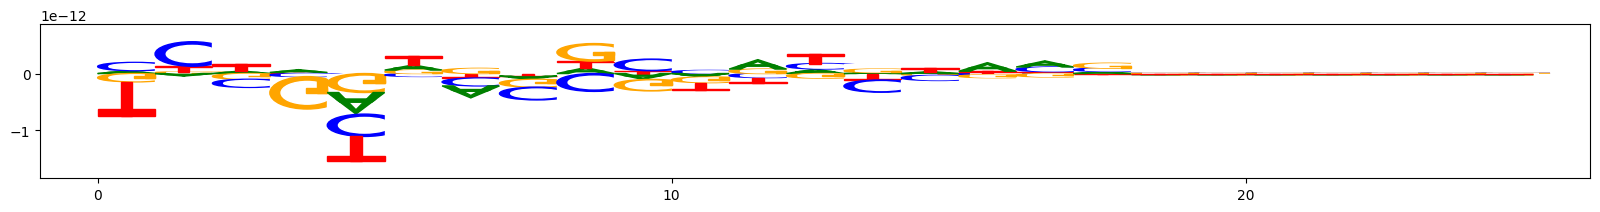

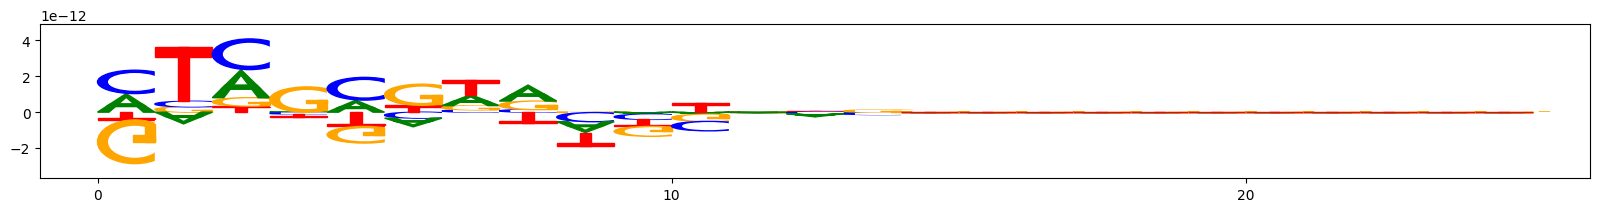

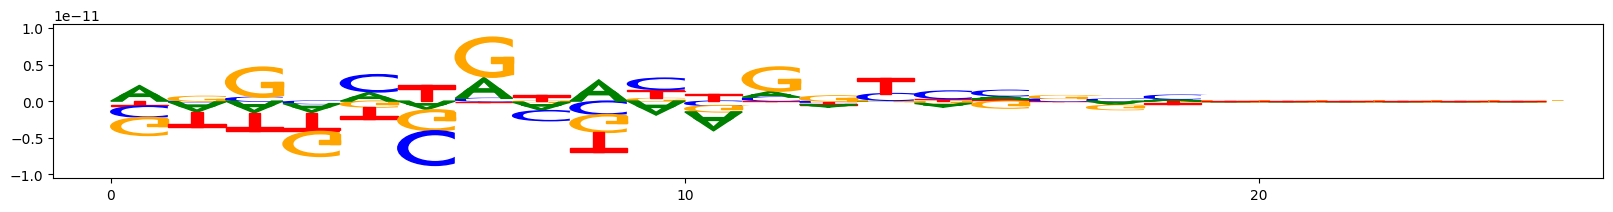

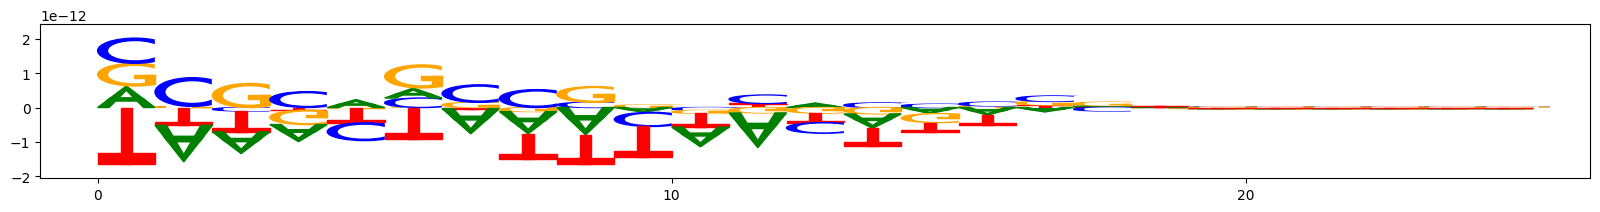

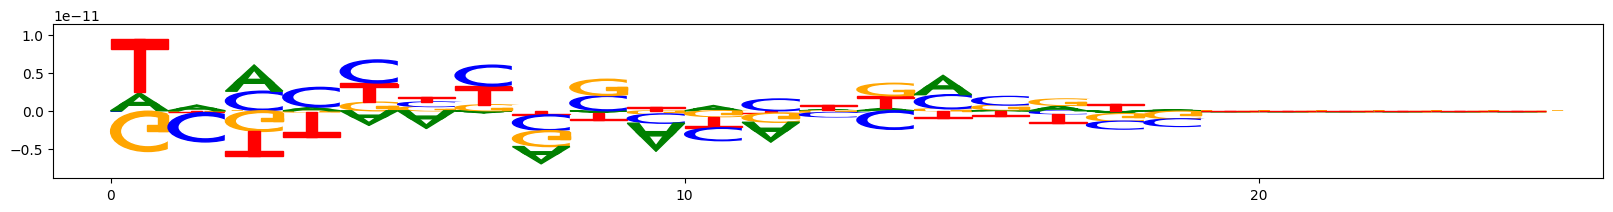

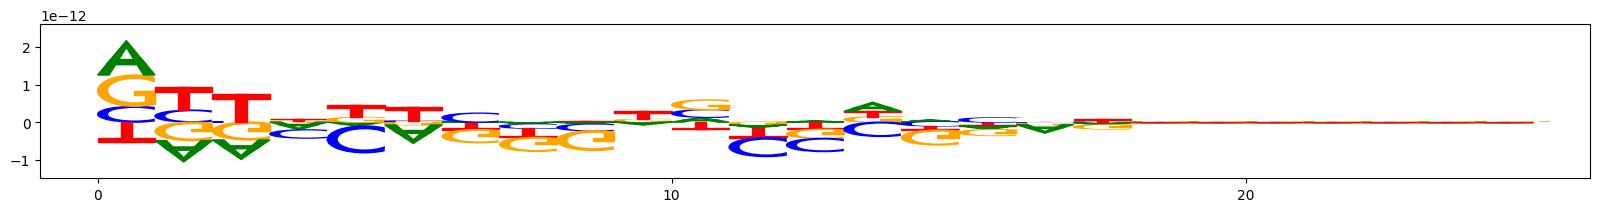

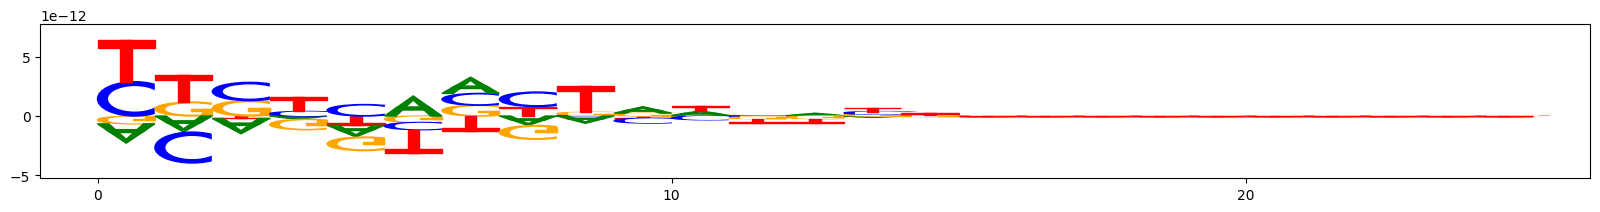

In [17]:
"""
    Compute and Plot Gradients
"""

# selected_compartments = ["ERM", "KDEL", "LMA", "MITO", "NES", "NIK", "NLS", "NUCP", "OMM"]
selected_compartments = ["ERM"]

number_of_nucleotides = 25

start_of_gradient = max_seq_len - number_of_nucleotides
end_of_gradient = max_seq_len

for compartment in data_split_in_compartments_x:
    if compartment in selected_compartments:
        print(f"Computing gradient of - {compartment}")
        compartment_data = data_split_in_compartments_x[compartment]
        gradient_of_compartment = motif_utilities.get_gradients(model, compartment_data)

        if not os.path.isdir(f"motif_search/integrated_gradients/{compartment}"):
            os.mkdir(f"motif_search/integrated_gradients/{compartment}")

        for i in range(len(compartment_data)):
            if not exclude_zero_gradients(gradient_of_compartment[i][start_of_gradient:]):
                # motif_utilities.plot_weights(compartment_data[i][start_index:], subticks_frequency = 10)
                motif_utilities.plot_weights(gradient_of_compartment[i][start_of_gradient:end_of_gradient], subticks_frequency=10)
                #plt.show()
                plt.savefig(f'motif_search/integrated_gradients/{compartment}/{compartment}_seq{i}.png')